In [14]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pdb
import os
from pycocotools.coco import COCO
from skimage import io

font = {'family' : 'Arial',
        'weight' : 'normal',
        'size'   : 12}

matplotlib.rc('font', **font)

In [15]:
# src_root = '../../../../datasets/voc2012/'
# src_subset = 'images/'
# src_file = src_root+'annotations/instances_train2012.json'
# src_desc = 'train2017_voc12' 

src_root = './dataset/'
src_subset = ''
src_file = src_root+'train.json'
src_desc = 'train_coco' # a name (identifier) for the dataset

coco_obj = COCO(src_file)

loading annotations into memory...
Done (t=0.18s)
creating index...
index created!


In [4]:
# Reading the json file
with open(src_file, 'r') as f:
    root = json.load(f)

root.keys()

dict_keys(['info', 'licenses', 'images', 'categories', 'annotations'])

In [5]:
# Basic High Level Information

n_images = len(root['images'])
n_boxes = len(root['annotations'])
n_categ = len(root['categories'])

# height, width
heights = [x['height'] for x in root['images']]
widths = [x['width'] for x in root['images']]




print('Dataset Name: ',src_desc)
print('Number of images: ',n_images)
print('Number of bounding boxes: ', n_boxes)
print('Number of classes: ', n_categ)
print('Max min avg height: ', max(heights), min(heights), int(sum(heights)/len(heights)))
print('Max min avg width: ', max(widths), min(widths), int(sum(widths)/len(widths)))

Dataset Name:  train_coco
Number of images:  4883
Number of bounding boxes:  23144
Number of classes:  10
Max min avg height:  1024 1024 1024
Max min avg width:  1024 1024 1024


In [6]:
# Objects per image distribution

img2nboxes = {} # mapping "image id" to "number of boxes"

for ann in root['annotations']:
    img_id = ann['image_id']
    
    if img_id in img2nboxes.keys():
        img2nboxes[img_id] += 1
    else:
        img2nboxes[img_id] = 1

nboxes_list = list(img2nboxes.values())

min_nboxes = min(nboxes_list)
max_nboxes = max(nboxes_list)
avg_nboxes = int(sum(nboxes_list)/len(nboxes_list))

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


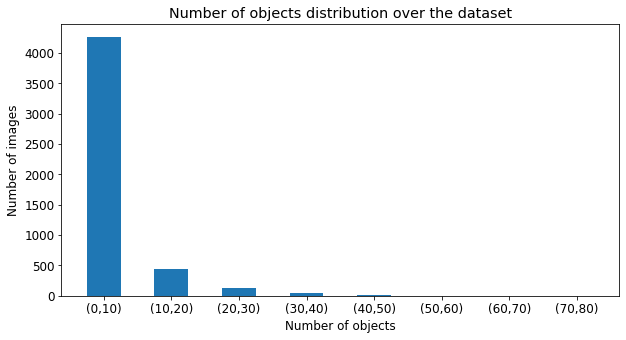

Number of images having atleast one box:  4883
Min number of boxes per image:  1
Max number of boxes per image:  71
Avg number of boxes per image:  4


In [7]:

out = pd.cut(nboxes_list, bins=np.arange(0,max_nboxes+10,10), include_lowest=True)

counts = out.value_counts().values
labels = [(int(i.left),int(i.right)) for i in out.value_counts().index.categories]

graph_xind = [i[0] for i in labels] 
ticks = [ '('+str(i[0])+','+ str(i[1])+')' for i in labels]

plt.figure(figsize=(10,5))
plt.bar(graph_xind, counts, tick_label=ticks, width=5)
plt.xlabel('Number of objects')
plt.ylabel('Number of images')
plt.title('Number of objects distribution over the dataset')
plt.show()

print("Number of images having atleast one box: ", len(nboxes_list))
print("Min number of boxes per image: ", min_nboxes)
print("Max number of boxes per image: ", max_nboxes)
print("Avg number of boxes per image: ", avg_nboxes)

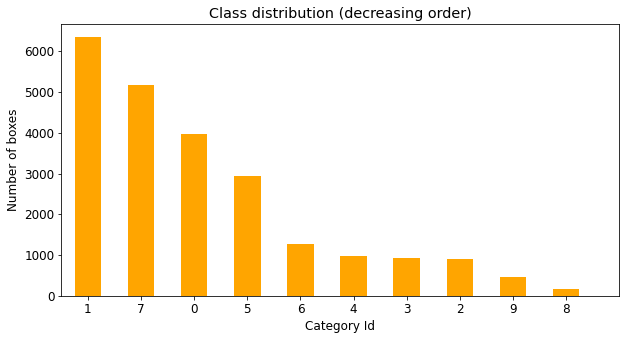

0 -> General trash, 1 -> Paper, 2 -> Paper pack, 3 -> Metal, 4 -> Glass, 5 -> Plastic, 6 -> Styrofoam, 7 -> Plastic bag, 8 -> Battery, 9 -> Clothing, 

In [8]:

# Class distribution
class2nboxes = {} 

for ann in root['annotations']:
    cat_id = ann['category_id']
    
    if cat_id in class2nboxes.keys():
        class2nboxes[cat_id] += 1
    else:
        class2nboxes[cat_id] = 1

sorted_c2nb = [(k,v)for k, v in sorted(class2nboxes.items(), reverse=True, key=lambda item: item[1])]

# top 20 classes
top = min(len(sorted_c2nb),20)

# to plot
y = [i[1] for i in sorted_c2nb[:top]]
x = [i[0] for i in sorted_c2nb[:top]]

plt.figure(figsize=(10,5))
plt.bar(np.arange(len(y)),y, width=0.5,tick_label=x,color='orange')
plt.xlim(-0.5,len(y))
plt.xlabel('Category Id')
plt.ylabel('Number of boxes')
plt.title('Class distribution (decreasing order)')
plt.show()



categ_map = {x['id']: x['name'] for x in root['categories']}
for k in categ_map.keys():
    print(k,'->',categ_map[k], end=", ")

In [9]:
# Class wise bounding box area distribution

bbox_areas = {} # key: class index, value -> a list of bounding box areas

for ann in root['annotations']:
    area = ann['area']
    cat_id = ann['category_id']
    
    if area <= 0.0:
        continue
    
    if cat_id in bbox_areas.keys():
        bbox_areas[cat_id].append(area)
    else:
        bbox_areas[cat_id] = [area]


bbox_avg_areas = []

for cat in bbox_areas.keys():
    areas = bbox_areas[cat]
    avg_area = int(sum(areas)/len(areas))
    
    bbox_avg_areas.append((cat,avg_area))

bbox_avg_areas = sorted(bbox_avg_areas, key = lambda x: x[1])

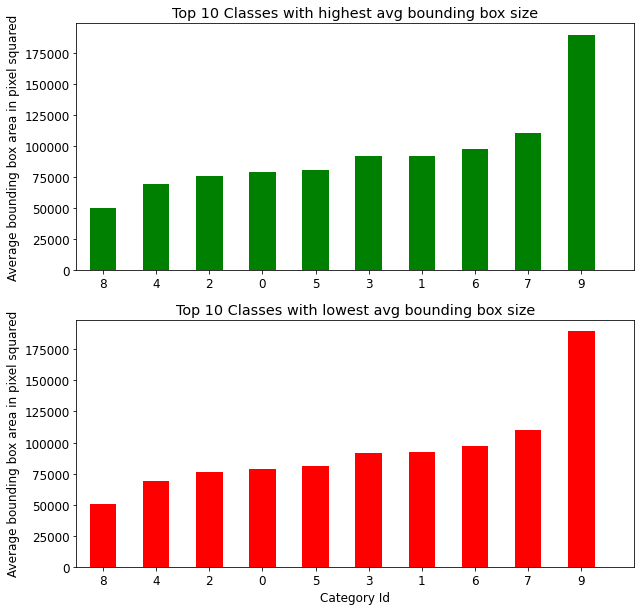

0 -> General trash, 1 -> Paper, 2 -> Paper pack, 3 -> Metal, 4 -> Glass, 5 -> Plastic, 6 -> Styrofoam, 7 -> Plastic bag, 8 -> Battery, 9 -> Clothing, 

In [10]:
top = min(10, len(bbox_avg_areas))

plt.figure(figsize=(10,10))

y = [item[1] for item in bbox_avg_areas[-top:]]
x = [item[0] for item in bbox_avg_areas[-top:]]

y2 = [item[1] for item in bbox_avg_areas[:top]]
x2 = [item[0] for item in bbox_avg_areas[:top]]

plt.subplot(211)
plt.bar(np.arange(len(y)),y, width=0.5,tick_label=x,color='green')
plt.xlim(-0.5,len(y))
# plt.xlabel('Category Id')
plt.ylabel('Average bounding box area in pixel squared')
plt.title('Top '+str(top)+' Classes with highest avg bounding box size')


plt.subplot(212)
plt.bar(np.arange(len(y2)),y2, width=0.5,tick_label=x2,color='red')
plt.xlim(-0.5,len(y2))
plt.xlabel('Category Id')
plt.ylabel('Average bounding box area in pixel squared')
plt.title('Top '+str(top)+' Classes with lowest avg bounding box size')
plt.show()




categ_map = {x['id']: x['name'] for x in root['categories']}
for k in categ_map.keys():
    print(k,'->',categ_map[k], end=", ")